# Introduction
***
Cet outil permet de concevoir un hacheur survolteur (boost converter) en prévisualisant l'efficacité selon les caractéristiques des composantes choisies. La topologie étudiée est représentée par la schématique suivante:

![dcdc](https://github.com/guimauve007/MPPT-builder/blob/main/assets/dcdc_boost.png?raw=1)

En fonctionnement continu, on observe le comportement suivant:

![traces](https://github.com/guimauve007/MPPT-builder/blob/main/assets/IL1_VGS.png?raw=1)



# Caractéristiques des composantes
***
Ici, on peut entrer les caractéristiques des composantes choisies pour le survolteur:

In [106]:
# Inductance (L1)
L = 550*10**-6 # Valeur de l'inductance (en Henry)
RL = 40*10**-3 # Résistance DC de la bobine (en Ohms)


In [107]:
# Switching FET (Q1)
RDS_SW = 12*10**-3 # Résistance entre le drain et la source (en Ohms)
CDS_SW = 400*10**-12 # Capacitance entre le drain et la source (en Farads)
T_SW = 26*10**-9 # en s -> temps de transition on-off moyen (en secondes)

In [108]:
# Rectifier FET (Q2)
RDS_RECT = 12*10**-3 # Résistance entre le drain et la source (en Ohms)

# Équations
***
La section suivante présente les différentes relations que l'on peut retrouver dans la topologie présentée plus haut.

## Nomenclature
---
Les différentes variables utilisées dans les équations sont définies ci-dessous:
<br><br>

$D$ = Duty Cycle (\%)

$\Delta i$ = Variation de courant dans l'inductance (demi hauteur) (A)

$I_{MPP}$ = Courant moyen dans l'inductance (A)

$f$ = Fréquence de commutation (Hz)

$T$ = Période (Secondes)

$L$ = Inductance (H)

$T_{on}$ = Temps $ON$ de $Q1$ (Secondes)

$T_{off}$ = Temps $OFF$ de $Q1$ (Secondes)

$T_{SW(on)}$ = Temps de montée de $Q1$

$T_{SW(off)}$ = Temps de descente de $Q1$








## Variation de courant
---
Sachant que la tension aux bornes d'une inductance est directement proportionnelle à la dérivée du courant qui y circule, on peut établir la relation suivante, où $\Delta i$ correspond à la variation de courant (demi hauteur):

$$ V_{in}=L\cdot \frac{(2\cdot di)}{dt}= L\cdot \frac{(2\cdot \Delta i)}{T_{on}}$$

$$⇒ Δi=\frac{V_{in}}{L\cdot 2}\cdot T_{on}$$

$$⇒ \Delta i=\frac{V_{in}}{L\cdot 2}\cdot \frac{D}{f} \tag{1}$$


In [109]:
def delta_i(vin, d, f, l):
    return (vin*d)/(l*2*f)

## Rapport cyclique
---

En reprenant la même équation présentée plus haut, soit la relation entre la dérivée du courant et la tension aux bornes de l'inductance, on peut isoler $\Delta t$ afin de déduire le ratio entre $T_{on}$ et la période $(T)$ pour trouver le rapport cyclique:

$$V_{in}=L\cdot \frac{(2\cdot \Delta i)}{T_{on}}$$

$$⇒T_{on}=\frac{L\cdot (2\cdot \Delta i)}{V_{in}}$$

Même principe pour $T_{off}$:

$$(V_{out}-V_{in})=L\cdot \frac{(2\cdot \Delta i)}{T_{off}}$$

$$⇒T_{off}=\frac{L\cdot (2\cdot \Delta i)}{(V_{out}-V_{in})}$$

On peut maintenant résoudre pour $D$:

$$D=\frac{T_{on}}{T_{on}+T_{off}}$$

$$⇒ D=1-\frac{V_{in}}{V_{out}} \tag{2}$$



In [110]:
def duty_cycle(vin, vout):
    return 1-(vin/vout)

## Pertes de rectification (Q2)
---
Au lieu d'utiliser une simple diode de type Schottky en sortie, on utilise un Mosfet (Q2) avec une faible résistance en conduction. La perte induite dans cette composante est calculée comme suit:

$$P_{loss}=\frac{\int_{0}^{T_{off}} R_{DS} \cdot I_{R}^2 \,dt}{T}$$

On retrouve au numérateur l'intégrale de la puissance instantanée qui donne l'énergie totale dissipée dans le Mosfet en conduction, qu'on divise ensuite par la période pour obtenir la puissance moyenne pour un cycle complet. On peut substituer $I_{R}$ par:

$$I_{R}=I_{MPP}+\Delta i-\frac{2\Delta i}{T_{off}} \cdot t$$

Soit le courant instantané circulant dans le Mosfet pour $t\in[0,T_{off}]$.

Où $$ T_{off}=(1-D) \cdot T$$

Par substitution dans la première équation et par résolution de l'intégrale, on obtient:

$$⇒ P_{loss}=\frac{-(D-1) \cdot (\Delta i^2+3 \cdot I_{MPP}^2) \cdot R_{DS}}{3} \tag{3}$$

In [111]:
def ploss_q2(d, di, impp, rds_rect):
    return -((d-1)*(di**2+3*impp**2)*rds_rect)/3

## Pertes de commutation (Q1)
La perte de commutation est causée par le temps de commutation du mosfet principal (Q1). Cette perte est illustrée dans la figure suivante par le chevauchement entre le courant de drain ($I_{Drain}$) et la tension entre le drain et la source ($V_{DS}$) lors de la commutation:

![switching loss](https://github.com/guimauve007/MPPT-builder/blob/main/assets/switching_loss.png?raw=1)

On considérera le pire des scénarios où il y a un chevauchement <u>complet</u> des deux courbes. De plus, on prendra les hypothèses suivantes:

$$T_{SW(off)}=T1=T2$$

$$T_{SW(on)}=T3=T4$$

(...) à développer

Pour une période complète, l'énergie perdue est calculée comme suit:

$$E_{loss}=2 \cdot T_{SW} \cdot I_{MPP} \cdot V_{DS}$$

La puissance totale dissipée à une fréquence donnée devient donc:

$$P_{loss}=2 \cdot T_{SW} \cdot I_{MPP} \cdot V_{DS} \cdot f \tag{4}$$


In [112]:
def ploss_q1_sw(impp, f, t_sw, vout):
    return 2*t_sw*impp*vout*f

## Pertes DC du MOSFET principal
La puissance dissipée dans le mosfet principal en conduction est représentée par l'équation qui suit:

$$ P_{loss}=\frac{\int_{0}^{T_{on}} R_{DS} \cdot I_M^2\,dt}{T}$$

Où
$$ I_M=I_{MPP}-\Delta i+2 \cdot \Delta i \cdot \frac{t}{T_{on}} $$

En résolvant la première équation, on obtient:

$$P_{loss}=D \cdot R_{DS} \cdot (I_{MPP}^2+\frac{\Delta i^2}{3}) \tag{5}$$



In [113]:
def ploss_fet(d, rds, impp, di):
  return d*rds*(impp**2+(di**2/3))

## Pertes DC de l'inductance (L1)
---
Pour calculer les pertes dans l'inductance $L1$, on trouve l'énergie totale dissipée pendant une période complète, et on divise par cette même période pour obtenir la puissance moyenne par cycle:

$$P_{loss}=\frac{\int_{0}^{T_{on}} R_L\cdot I_{L(on)}^2\ dt + \int_{0}^{T_{off}} R_L\cdot I_{L(off)}^2\ dt}{(T_{on}+T_{off})}$$

Où

$$I_{L(on)}=(I_{MPP}-\Delta i)+\frac{2\cdot \Delta i}{T_{on}}\cdot t$$

$$I_{L(off)}=(I_{MPP}+\Delta i)+\frac{2\cdot \Delta i}{T_{off}}\cdot t$$

Par résolution de la première équation, on obtient:

$$P_{loss}=R_L \cdot [(I_{MPP})^2+\frac{\Delta I^2}{3}] \tag{6}$$


In [114]:
def ploss_l1(impp, delta_i, rl):
    return rl*((impp**2)+((delta_i**2)/3))

## Pertes de commutation ($C_{DS}$)
---

Pertes de commutation lié au condensateur parallèle $C_{DS}$. Cette perte est causée par la décharge de celui-ci lorsque le Mosfet commute:

$$P_{loss}=\frac{1}{2} \cdot C_{DS} \cdot (V_{out})^2 \cdot f \tag{7}$$

In [115]:
def ploss_q1_cds(f, vout, cds_sw):
    return (1/2)*cds_sw*(vout**2)*f

# Pertes totales
---

In [116]:
def ploss_tot(f, i_mpp, vin, vout):

  # caractéristiques du hacheur
  l = L
  rl = RL
  rds_sw = RDS_SW
  cds_sw = CDS_SW
  t_sw = T_SW
  rds_rect = RDS_RECT

  # variables de fonctionnement
  d = duty_cycle(vin, vout)
  di = delta_i(vin, d, f, l)

  # pertes totales
  return ploss_q2(d, di, i_mpp, rds_rect) + ploss_q1_sw(i_mpp, f, t_sw, vout) + ploss_fet(d, rds_sw, i_mpp, di) + ploss_l1(i_mpp, di, rl) + ploss_q1_cds(f, vout, cds_sw)

In [117]:
def efficiency(f, i_mpp, vin, vout):
  p_in = vin*i_mpp
  p_out = p_in - ploss_tot(f, i_mpp, vin, vout)

  return p_out/p_in

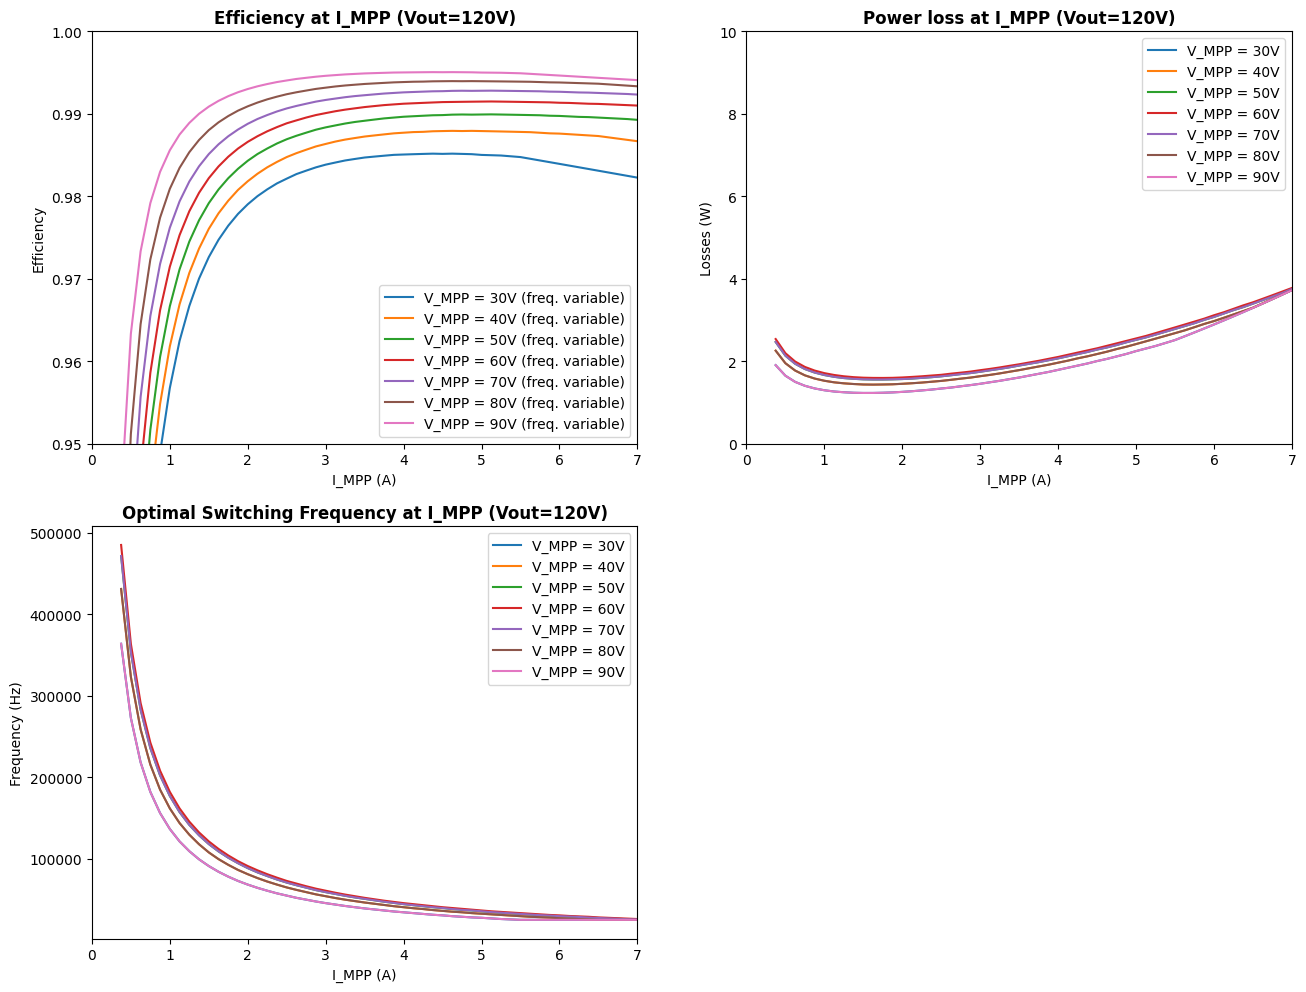

In [118]:
import numpy as np
import matplotlib.pyplot as plt

V_OUT = 120 # V
MAX_RIPPLE_RATIO = 0.15 # pourcentage de I_MPP
MIN_FREQUENCY = 25000 # Hz
MAX_FREQUENCY = 500000 # Hz
MAX_I_MPP = 7 # A
MAX_V_MPP = 90 # V

v_mpp = np.arange(30, MAX_V_MPP + 1, 10)
i_mpp = np.arange(0, MAX_I_MPP + 0.1, 0.125)
frequency = np.arange(MIN_FREQUENCY, MAX_FREQUENCY + 1, 250)

max_efficiency = 0
best_frequency = 0
power_loss = 0

efficiency_list = []
max_efficiency_list = []
best_frequency_list = []
loss_list = []

for v in v_mpp:
  for i in i_mpp:
    for f in frequency: # On cherche la fréquence qui retourne la meilleure efficacité
      if(delta_i(v, duty_cycle(v, V_OUT), f, L) < i*MAX_RIPPLE_RATIO):
        efficiency_list.append([efficiency(f, i, v, V_OUT), f])
      else:
        efficiency_list.append([0,0])

    max_efficiency = max(efficiency_list, key = lambda x: x[0])[0] # On trouve l'efficacité optimale à i_mpp
    max_efficiency = None if max_efficiency == 0 else max_efficiency# On remplace les 0 par des NULL pour mieux interpréter les graphiques
    best_frequency = max(efficiency_list, key = lambda x: x[0])[1] # On trouve la fréquence qui maximise l'efficacité pour i_mpp
    best_frequency = None if best_frequency == 0 else best_frequency
    power_loss = None if max_efficiency == None else v*i*(1-max_efficiency)

    max_efficiency_list.append(max_efficiency)
    best_frequency_list.append(best_frequency)
    loss_list.append(power_loss)

    efficiency_list.clear() # On vide la liste pour recommencer avec un nouveau courant i_mpp

  # On remplit les données pour chaque v_mpp
  plt.subplot(2,2,1)
  plt.plot(i_mpp, max_efficiency_list, label="V_MPP = " + str(v) + "V (freq. variable)")
  plt.subplot(2,2,3)
  plt.plot(i_mpp, best_frequency_list, label="V_MPP = " + str(v) + "V")
  plt.subplot(2,2,2)
  plt.plot(i_mpp, loss_list, label="V_MPP = " + str(v) + "V")
  max_efficiency_list.clear()
  best_frequency_list.clear()
  loss_list.clear()

# On calcule les valeurs minimales de condensateur (à fréquence minimale de switching)
#plt.subplot(2,2,4)
#table_data = [['Composante', 'Valeur', 'Unités'],
#              ['C1', ' ', ' '],
#              ['C2', ' ', ' ']]
#plt.table(cellText=table_data, loc=('top',0.1))
#plt.title("Condensateurs requis")
#plt.axis('off')

plt.subplot(2,2,1)
plt.xlabel("I_MPP (A)")
plt.ylabel("Efficiency")
plt.ylim(0.95, 1)
plt.xlim(0, 7)
plt.legend()
plt.title("Efficiency at I_MPP (Vout="+str(V_OUT)+"V)", fontweight ="bold")

plt.subplot(2,2,2)
plt.xlabel("I_MPP (A)")
plt.ylabel("Losses (W)")
plt.ylim(0, 10)
plt.xlim(0, 7)
plt.legend()
plt.title("Power loss at I_MPP (Vout="+str(V_OUT)+"V)", fontweight ="bold")

plt.subplot(2,2,3)
plt.xlabel("I_MPP (A)")
plt.ylabel("Frequency (Hz)")
plt.xlim(0, 7)
plt.legend()
plt.title("Optimal Switching Frequency at I_MPP (Vout="+str(V_OUT)+"V)", fontweight ="bold")

plt.subplots_adjust(top=2, right=2)
plt.show()
